In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc, matplotlib as mpl,numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

### Load the dataset
We will load the dataset from HuggingFace Hub:

In [3]:
x,y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

To make like simpler (mostly with the model architecture), we'll resize the 28x28 images to 32X32:

In [4]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [5]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

### Create Model
We will create a U-net.

In [7]:
from diffusers import UNet2DModel

In [8]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))

### Training - easy with a callback!

In [9]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device) # noise, x_T
        x0 = learn.batch[0] # original images, x0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε # noisify the image
        # input to our model is noisy imagea nd timestep, ground turth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz, learn):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1] if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1= 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

    


In [10]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.056,0,train
0.026,0,eval
0.021,1,train
0.020,1,eval
0.019,2,train
0.018,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.015,4,eval


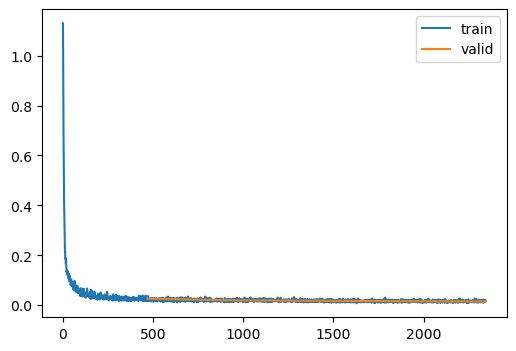

In [11]:
learn.fit(epochs)

In [12]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [13]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [14]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

### Inference

In [15]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16,1,32,32), learn)
len(samples)

1000

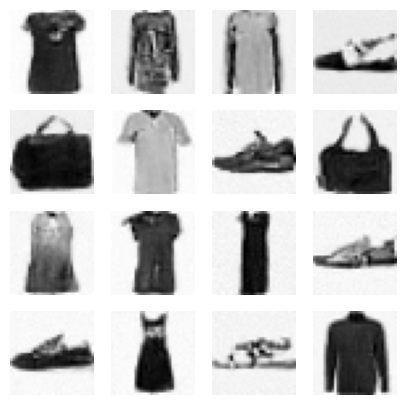

In [16]:
show_images(-samples[-1], figsize=(5,5))

In [ ]:
#%matplotlib auto

import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))